In [1]:
#!/usr/bin/env python3
"""logistic_regression
James Gardner 2019
following tutorials online, + Matthew Alger

performs logistic regression on feature vectors
against positional matching labels
using pytorch
"""

import csv
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

import torch
from torch.autograd import Variable
import torch.nn.functional as F

In [2]:
# Step 1. Load Dataset
# Step 2. Make Dataset Iterable
catalogue = pd.read_csv('patch_catalogue.csv')
catalogue.set_index(['name_TGSS','name_NVSS'],inplace=True)

scores = catalogue['score']
del (catalogue['ra_TGSS'],catalogue['dec_TGSS'],
     catalogue['ra_NVSS'],catalogue['dec_NVSS'],
     catalogue['score'])

catalogue['log_flux_TGSS']       = np.log10(catalogue['peak_TGSS'])
catalogue['log_integrated_TGSS'] = np.log10(catalogue['integrated_TGSS'])
catalogue['log_ratio_flux_TGSS'] = np.log10(catalogue['peak_TGSS']/
                                            catalogue['integrated_TGSS'])
catalogue['log_flux_NVSS']       = np.log10(catalogue['peak_NVSS'])

In [3]:
labels = (scores.values > 0.1)
features = catalogue.values

# A: training set, B: prediction set
labels_A,   labels_B   = labels[::2],   labels[1::2]
features_A, features_B = features[::2], features[1::2]

labels_A = Variable(torch.from_numpy(labels_A).float())
labels_B = Variable(torch.from_numpy(labels_B).float())
features_A = Variable(torch.Tensor(features_A))
features_B = Variable(torch.Tensor(features_B))

In [4]:
# Step 3. Create Model Class
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear = torch.nn.Linear(input_dim, 1)
        
    def forward(self, x):
        outputs = F.sigmoid(self.linear(x))
        return outputs

In [5]:
# some of the hyper-parameters
input_dim = features_A.shape[1]
# time-step
learning_rate = 0.001

# batch_size = 100
# n_iters    = 3000
# num_epochs = n_iters / (len(x_data) / batch_size)
num_epochs = int(1e5)

In [6]:
# Step 4. Instantiate Model Class
# Step 5. Instantiate Loss Class
# Step 6. Instantiate Optimizer Class
model = LogisticRegression(input_dim)
# criterion = torch.nn.CrossEntropyLoss()
criterion = torch.nn.BCELoss(size_average=True)
# unbiased estimate (noisy observation)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

/home/james/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [7]:
# Step 7. Train Model
losses = []
for epoch in tqdm(range(num_epochs)):
    # reset gradient accumulation
    optimizer.zero_grad()
    # forward step
    predictions = model(features_A)
    loss = criterion(predictions, labels_A)
    # use item to stop memory leak to GPU <- M.Alger advice
    losses.append(loss.item())
    # backwards step
    loss.backward()
    optimizer.step()

/home/james/.local/lib/python3.6/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/james/.local/lib/python3.6/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([15332])) that is different to the input size (torch.Size([15332, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


In [8]:
predictions = model(features_B).detach().numpy()
pred_labels = (predictions > 0.5).astype(float)
labels_B_to_compare = np.resize(labels_B.numpy(),(len(labels_B.numpy()),1))
accuracy = (pred_labels == labels_B_to_compare).mean()
# conditional accuracy, precision (true if said so), recall (said so if true)
precision = (labels_B_to_compare[pred_labels == True] == True).mean()
recall    = (pred_labels[labels_B_to_compare == True] == True).mean()
print('accuracy =',accuracy,
      'precision =',precision,
      'recall =',recall,sep='\n')
# print(np.unique(pred_labels,return_counts=True),np.unique(labels_B.numpy(),return_counts=True))

accuracy =
0.8022436733629011
precision =
0.32061068702290074
recall =
0.07508044333214157


/home/james/.local/lib/python3.6/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


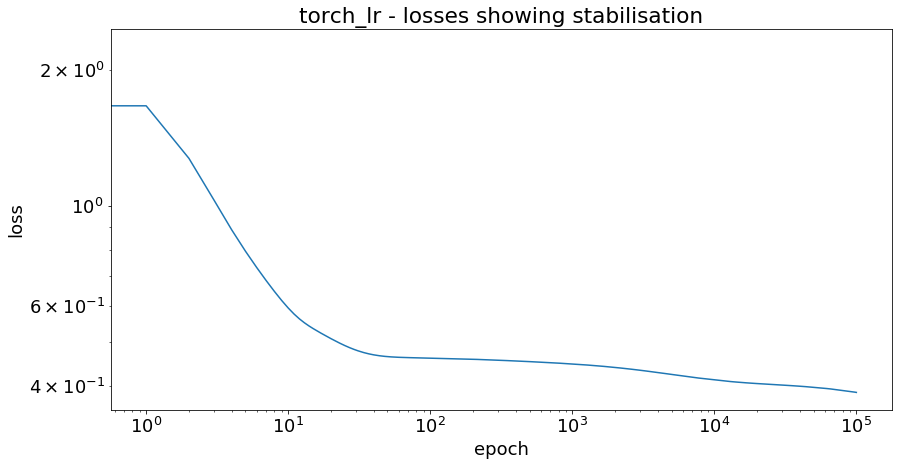

In [9]:
plt.figure(figsize=(14,7))
plt.rcParams.update({'font.size': 18})
plt.plot(losses)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('torch_lr - losses showing stabilisation')
plt.savefig('torch_lr_losses.pdf',bbox_inches='tight') 

In [10]:
parameters = list(model.parameters())
weights = parameters[0].detach().numpy().ravel()
bias = parameters[1].detach().numpy()

# also saves bias onto the end, needed to reconstruct model
np.savetxt('weights.csv', np.concatenate((weights,bias)), delimiter=',')

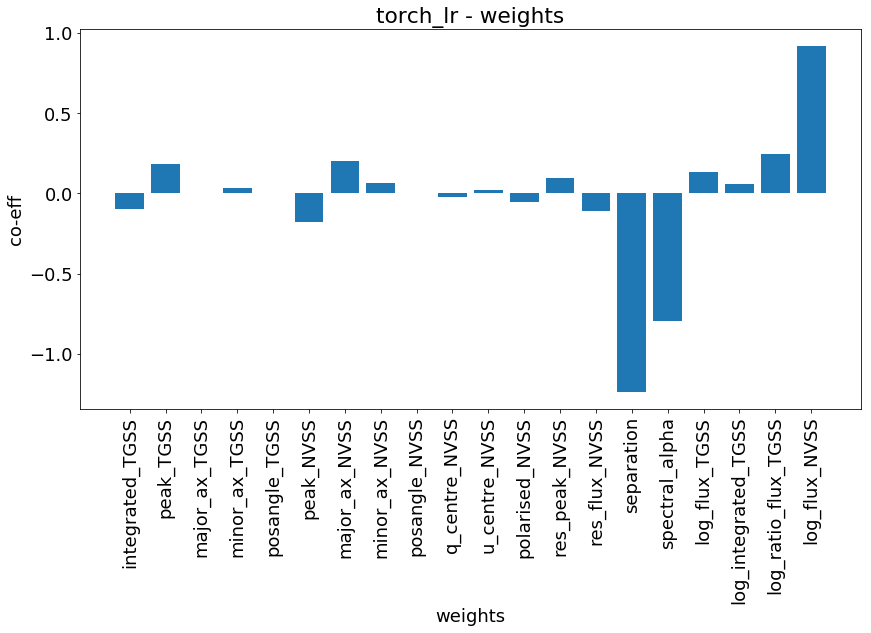

In [11]:
plt.figure(figsize=(14,7))
plt.rcParams.update({'font.size': 18})
plt.bar(range(len(weights)),weights)
plt.xlabel('weights')
plt.xticks(range(len(weights)),catalogue.columns,rotation='vertical')
plt.ylabel('co-eff')
plt.title('torch_lr - weights')
plt.savefig('torch_lr.pdf',bbox_inches='tight') 
# plt.close()

In [12]:
labels_cat = Variable(torch.from_numpy(labels).float())
features_cat = Variable(torch.Tensor(features))

predictions_cat = model(features_cat).detach().numpy()
# dodgy predictor, populations are roughly even so why is it constant?
# ultimately should just be >0.5 but predictor is bad
pred_labels_cat = (predictions_cat > predictions_cat.mean()).astype(float)

catalogue['pred_labels'] = pred_labels_cat
catalogue['pred_labels'].to_csv('predictions.csv')

/home/james/.local/lib/python3.6/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/lib/python3/dist-packages/ipykernel_launcher.py:10: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  # Remove the CWD from sys.path while we load stuff.


In [13]:
def inv_sigmoid(y):
    """y = 1/(e^-x+1)"""
    x = np.log(y/(1-y))
    return x

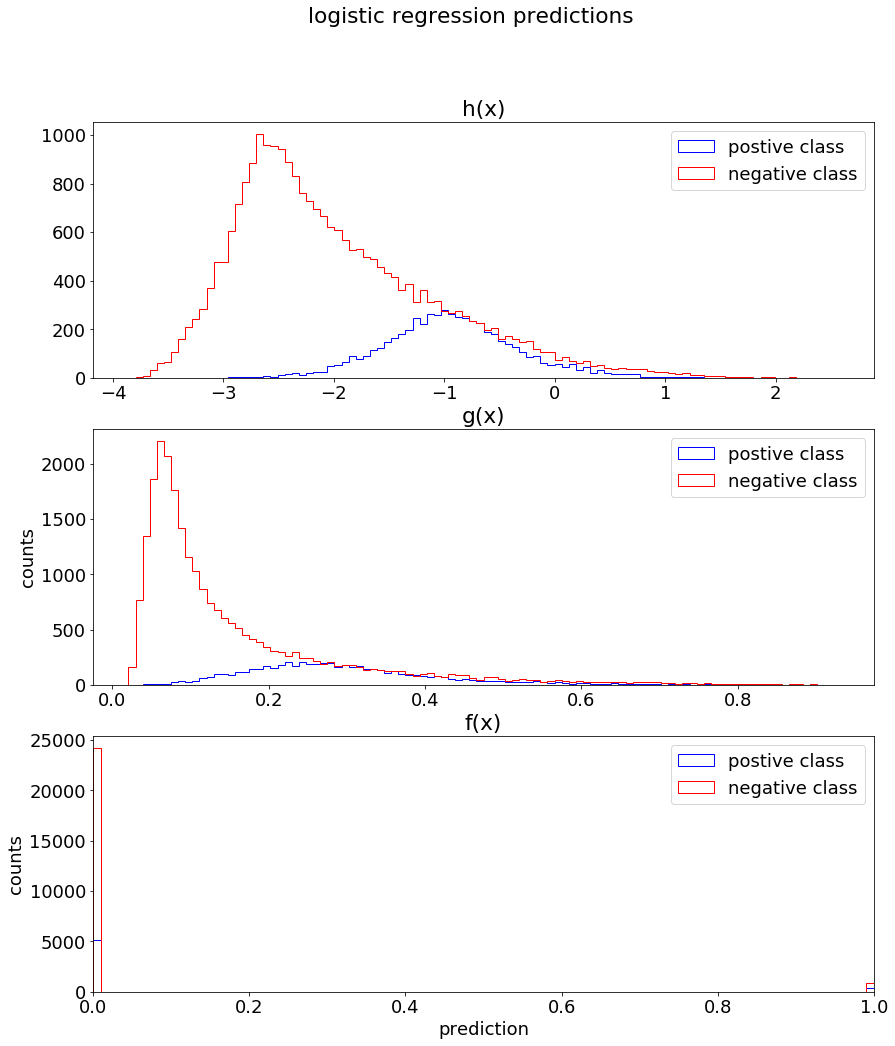

In [14]:
plt.rcParams.update({'font.size': 18})
fig, (ax1, ax2, ax3) = plt.subplots(3,figsize=(14,16))
fig.suptitle('logistic regression predictions')
ax1.set_title('h(x)')
ax2.set_title('g(x)')
ax3.set_title('f(x)')
ax2.set_ylabel('counts')
ax2.set_ylabel('counts')
ax3.set_ylabel('counts')
ax3.set_xlabel('prediction')
ax1.hist((inv_sigmoid(predictions_cat[labels == 0]),
          inv_sigmoid(predictions_cat[labels == 1])), bins=100,
         histtype='step', label=('negative class','postive class'), color = ('red','blue'))
ax1.legend()
# ax3.set_xlim((-0.75,0))
ax2.hist((predictions_cat[labels == 0],predictions_cat[labels == 1]), bins=100,
         histtype='step', label=('negative class','postive class'), color = ('red','blue'))
ax2.legend()
ax3.hist((np.round(predictions_cat[labels == 0]),
          np.round(predictions_cat[labels == 1])), bins=100, histtype='step', 
         label=('negative class','postive class'), color = ('red','blue'))
ax3.legend()
ax3.set_xlim((0,1))

plt.savefig('lr_predictions.pdf',bbox_inches='tight')

In [15]:
# partition the sky
cat_pairs = set(catalogue.index.values)
obj_pairs = []

for pair in tqdm(cat_pairs):
    if catalogue.loc[pair]['pred_labels'] == 1:
        obj_pairs.append(pair)

In [16]:
objects = {}
tnames = {}
nnames = {}

index = 0
for pair in tqdm(obj_pairs):
    tname, nname = pair[0], pair[1]
    
    if not tname in tnames and not nname in nnames:
        i = index
        objects[i] = [tname,nname]
        tnames[tname] = i
        nnames[nname] = i
    elif tname in tnames and not nname in nnames:
        i = tnames[tname]
        objects[i].append(nname)
        nnames[nname] = i
    elif not tname in tnames and nname in nnames:
        i = nnames[nname]
        objects[i].append(tname)
        tnames[tname] = i
    elif tname in tnames and nname in nnames:
        # must merge objects, zig-zag problem
        i = tnames[tname]
        j = nnames[nname]
        if i == j:
            continue
        else:
            obj_i = objects[i]
            obj_j = objects[j]
            merged_obj = list(set(obj_i+obj_j))
            objects[index] = merged_obj
            del objects[i], objects[j] 
            for name in merged_obj:
                if   name[0] == 'T':
                    tnames[name] = index
                elif name[0] == 'N':
                    nnames[name] = index
        
    index += 1

In [21]:
multi_objects = {}
most_components = 0
most_components_i = 0
for key, val in objects.items():
    if len(val) > 2:
        multi_objects[key] = val
        if len(val) > most_components:
            most_components = len(val)
            most_components_i = key
print(most_components, multi_objects[most_components_i])

56 ['TGSSADR J101750.4-270547', 'NVSS J101654-270732', 'TGSSADR J101620.1-265903', 'TGSSADR J101620.9-265704', 'NVSS J101621-270024', 'TGSSADR J101906.3-270225', 'TGSSADR J101853.5-265610', 'NVSS J101620-265704', 'NVSS J101633-270219', 'TGSSADR J101456.7-265411', 'TGSSADR J101759.6-270143', 'NVSS J101545-270425', 'TGSSADR J101852.4-265703', 'NVSS J101432-265729', 'TGSSADR J101634.2-270221', 'TGSSADR J101432.4-265726', 'NVSS J101445-263911', 'TGSSADR J101509.4-270817', 'NVSS J101852-265656', 'NVSS J101908-270856', 'NVSS J101509-270818', 'NVSS J101449-270024', 'TGSSADR J101445.3-263910', 'TGSSADR J101745.2-270216', 'NVSS J101906-270231', 'NVSS J101456-265414', 'TGSSADR J101505.3-270623', 'TGSSADR J101747.2-265833', 'NVSS J101428-263946', 'TGSSADR J101558.6-271054', 'NVSS J101759-270146', 'TGSSADR J101558.6-270143', 'TGSSADR J101741.8-270149', 'NVSS J101436-270532', 'NVSS J101822-270043', 'TGSSADR J101436.8-270532', 'TGSSADR J101719.0-270208', 'NVSS J101742-270200', 'NVSS J101505-270624',

In [18]:
def dict_to_csv(dict_to_convert, filename):
    values = []
    for val in dict_to_convert.values():
        values.append(val)

    with open(filename, 'w', newline = '') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows(values)
    
dict_to_csv(objects,'objects.csv')
dict_to_csv(multi_objects,'multi_objects.csv')